In this example, we will use Multicell to simulate the self-organization of a geometrical Turing pattern (Turing 1952; Note about other proposals and ways to produce spatial patterns), based on equations developed by Gierer and Meinhardt (Gierer and Meinhardt 1972). These equations describe a simple molecular mechanism that involves two chemical species, an activator and a repressor. The activator activates itself, as well as the repressor. The repressor represses the activator. Both species are diffusible, the activator within a short-range, and the repressor within a longer range.
 
Despite its simplicity, this mechanism has been successfully used to explain the formation of many different molecular spatial patterns in tissue structures (Meinhardt and Gierer 1974; Meinhardt book 1982; Kondo 2010;). In this section, we will implement the Gierer-Meinhardt equations (Gierer and Meinhardt 1972).

# Preparation

In [1]:
%matplotlib notebook

# Imports

In [2]:
import multicell
import numpy as np

# Problem definition

## Simulation and tissue structure

In [3]:
sim = multicell.simulation_builder.generate_cell_grid_sim(20, 20, 1, 1e-3)

## Biological species

We register two species: an activator `a` and an inhibitor `h`.

In [4]:
sim.register_cell_variable("a")
sim.register_cell_variable("h")

## Computed variables

The concentrations of `a` will be computed automatically for all cells. However, we will be going to use their squares multiple times per time step. To avoid raising the vector `c_a` to the square multiple times, we define a computed variable `c_a2` that will be computed once per time step. The equation of `c_a2` is defined using a Python function, which is then registered using the method `register_computed_variable` of the Simulation object.

In [5]:
def c_a2(c_a, **kwargs):
    return c_a**2

sim.register_computed_variable("c_a2", c_a2)

## Constants

In [6]:
sim.set_constants({"mu_a": 1e-1, "mu_h": 2e-1, "rho_a": 1., "rho_h": 1., "q": 1., "H": 0.35, "A": 0., "D_h": 5., "D_a": 0.025})

## Differential equations

The formula of $\dfrac{da}{dt}$ is comprised of 4 additive terms: a diffusion term, an `a` and `h`-dependent synthesis term, a degradation term and a basal synthesis term.

In [7]:
def da_dt(simulation, a, c_a, c_a2, c_h, D_a, mu_a, rho_a, A, q, adjacency_matrix, **kwargs):
    return simulation.diffusion(D_a, c_a, adjacency_matrix) + rho_a * c_a2 / c_h / (1 + q**2 * c_a2) - mu_a * a + A

The formula of $\dfrac{dh}{dt}$ is similarly built, except for the fact that the variable synthesis term is only `a`-dependent.

In [8]:
def dh_dt(simulation, h, c_a2, c_h, D_h, mu_h, rho_h, H, adjacency_matrix, **kwargs):
    return simulation.diffusion(D_h, c_h, adjacency_matrix) + rho_h * c_a2 - mu_h * h + H

sim.set_ODE("a", da_dt)
sim.set_ODE("h", dh_dt)

## Initial conditions

In [9]:
sim.initialize_cell_variables()

We initialize initial quantities of matter to values that would be close to their steady state if there was no diffusion (i.e. if cells were independent). As cell volumes are all slightly different (the grid is noisy), concentrations will also all be slightly different and there is no need to randomize the initial quantities of matter.

In [10]:
a0 = np.full(sim.n_cells, 0.789)
h0 = np.full(sim.n_cells, 4.863)

sim.set_cell_variable("a", a0)
sim.set_cell_variable("h", h0)

## Duration

In [11]:
sim.set_duration(3200)
sim.set_time_steps(10, "linear")

## Rendering

In [12]:
sim.register_renderer(multicell.rendering.MatplotlibRenderer, "c_a", {"max_cmap": 1.3, "view": (90, -90), "axes": False})


# Visualization of the initial state

<IPython.core.display.Javascript object>


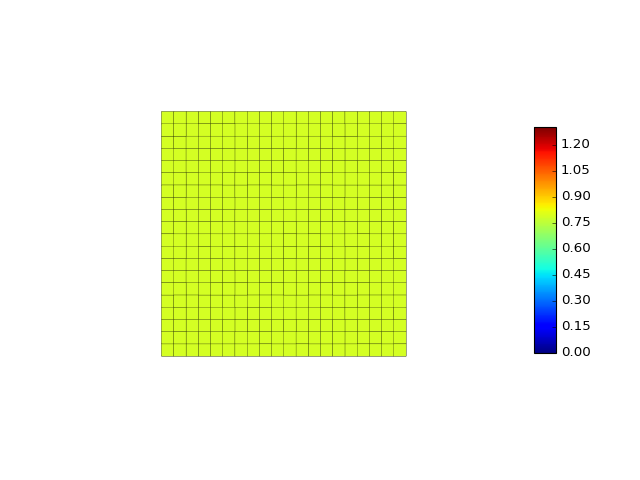

Time point: 0.0
c_a: from 0.788228162881 to 0.789659873063
c_h: from 4.85824278338 to 4.86706712637


In [13]:
sim.renderer.display("c_a")

# Simulation

<IPython.core.display.Javascript object>


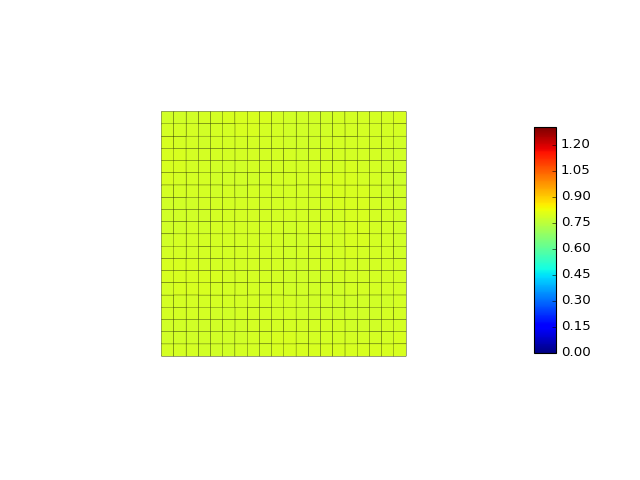

Time point: 320.0
c_a: from 0.781806847197 to 0.797008616332
c_h: from 4.85894991646 to 4.86695001149


<IPython.core.display.Javascript object>


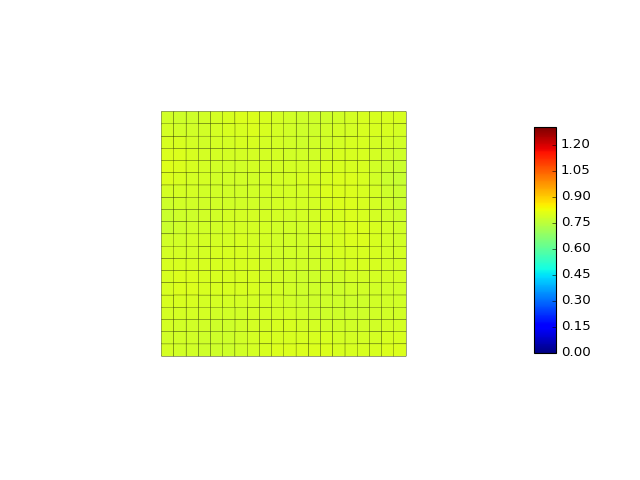

Time point: 640.0
c_a: from 0.7705723572 to 0.803274187002
c_h: from 4.85160793078 to 4.87119484636


<IPython.core.display.Javascript object>


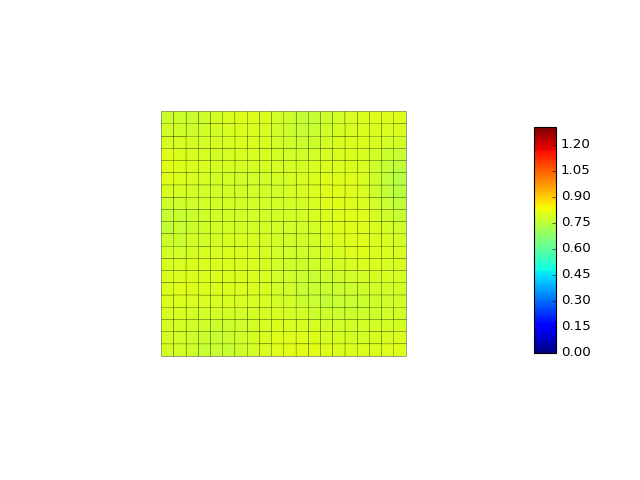

Time point: 960.0
c_a: from 0.746097809434 to 0.810505682637
c_h: from 4.83503063122 to 4.87731346203


<IPython.core.display.Javascript object>


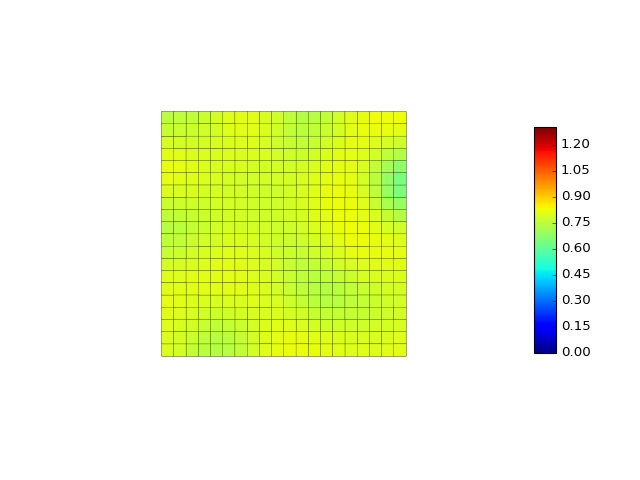

Time point: 1280.0
c_a: from 0.64620604886 to 0.832122044003
c_h: from 4.76930955931 to 4.88807147272


<IPython.core.display.Javascript object>


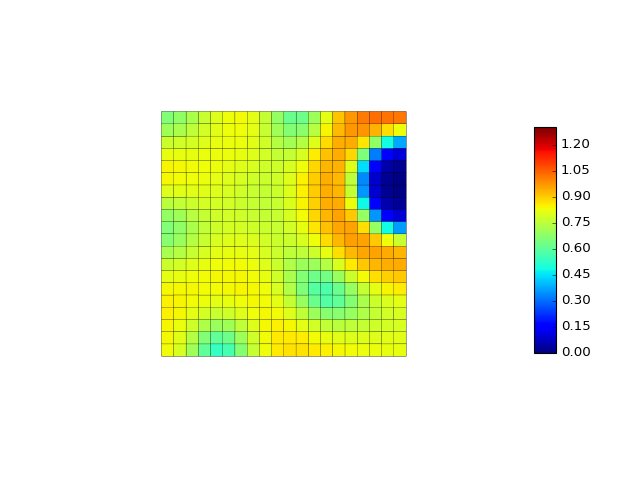

Time point: 1600.0
c_a: from 0.00901875548932 to 1.02589654178
c_h: from 4.17709866806 to 4.91607644148


<IPython.core.display.Javascript object>


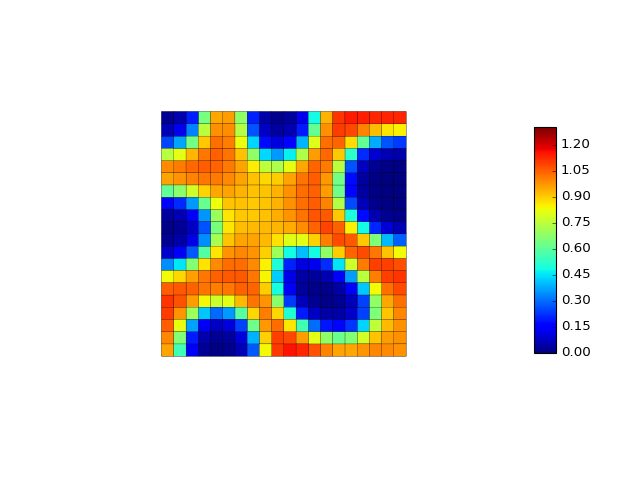

Time point: 1920.0
c_a: from 0.000985718098779 to 1.15520460574
c_h: from 3.89390531609 to 4.97909615217


<IPython.core.display.Javascript object>


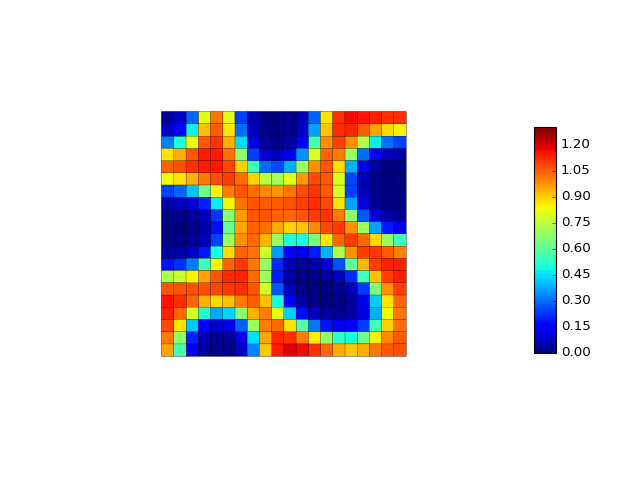

Time point: 2240.0
c_a: from 0.00157555109119 to 1.19071227519
c_h: from 3.95276251689 to 4.94712551959


<IPython.core.display.Javascript object>


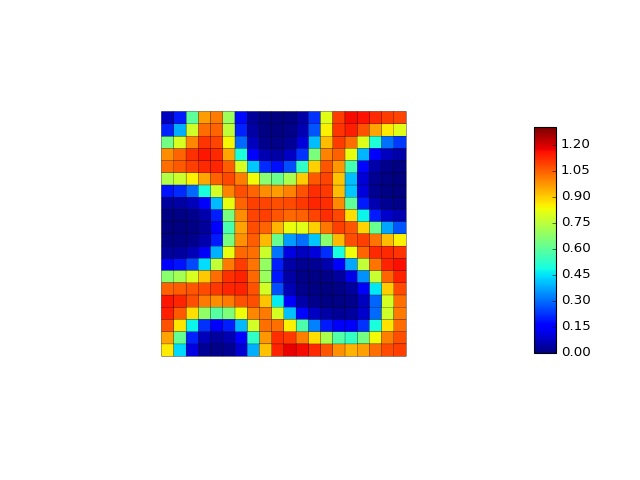

Time point: 2560.0
c_a: from 0.00237512302499 to 1.18098929272
c_h: from 3.9990489875 to 4.93609469925


<IPython.core.display.Javascript object>


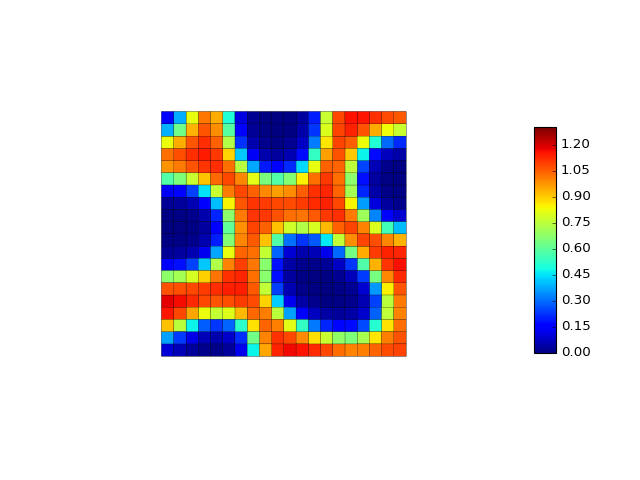

Time point: 2880.0
c_a: from 0.00202087337189 to 1.18516655765
c_h: from 3.98411206313 to 4.94743132335


<IPython.core.display.Javascript object>


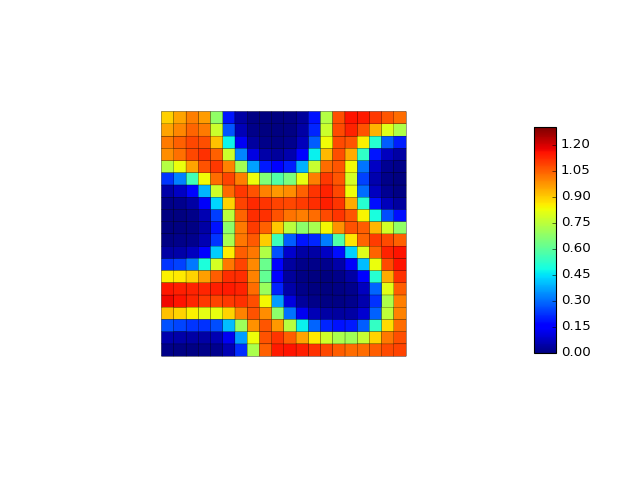

Time point: 3200.0
c_a: from 0.00165177882156 to 1.17067604275
c_h: from 3.9540135314 to 4.99260944466


In [14]:
sim.simulate()

<IPython.core.display.Javascript object>


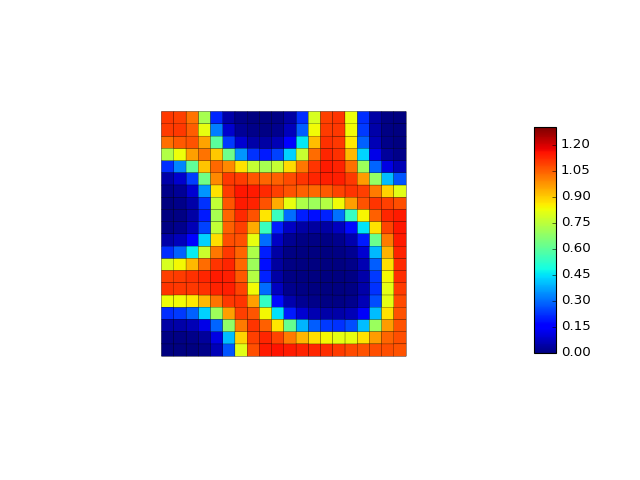

Time point: 10003200.0
c_a: from 0.000570907866976 to 1.1533638104
c_h: from 3.84099248772 to 5.00003554111


In [15]:
sim.set_duration(1e7)
sim.set_time_steps(1)
sim.simulate()

Small differences in concentrations amplified and propagated into a pattern.